In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [2]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) =  keras.datasets.cifar10.load_data()
print(train_images.shape,test_images.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3)


In [3]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',input_shape=(32,32,3))) # (32,32,3) é o input_size
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu')) # 64 é o número de filtros
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu')) # (3,3) é o tamanho do filtro

In [4]:
model.summary()
#conv2d (Conv2D)              (None, 30, 30, 32)        896 
#                                    30, 30 pois não fizemos o padding então perdemos 2x2 pixel
# C/ Isso temos o stack of max pooling and convolution

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


<p>Agora, Precisamos passar a informação contida na ultima camada para algum tipo de Dense Layer Classifier</p>

<p>Para ao final, termos qual combinação dessas informações do mapa são uma das 10 classes</p>

<h1>Adicionando o Dense Layer</h1>

In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10)) # 10 Outputs

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

<h2>Treinando</h2>

In [7]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

history = model.fit(train_images, train_labels, epochs=4,
                validation_data=(test_images,test_labels))

Epoch 1/4
1563/1563 [==============================] - 40s 26ms/step - loss: 1.7372 - accuracy: 0.4034 - val_loss: 1.3746 - val_accuracy: 0.5021
Epoch 2/4
1563/1563 [==============================] - 39s 25ms/step - loss: 1.3203 - accuracy: 0.5293 - val_loss: 1.2417 - val_accuracy: 0.5569
Epoch 3/4
1563/1563 [==============================] - 38s 25ms/step - loss: 1.1741 - accuracy: 0.5872 - val_loss: 1.1336 - val_accuracy: 0.6088
Epoch 4/4
1563/1563 [==============================] - 40s 26ms/step - loss: 1.0681 - accuracy: 0.6258 - val_loss: 1.0680 - val_accuracy: 0.6296


<h2>Avaliando</h2>

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels,verbose=1)
print(test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 1.0680 - accuracy: 0.6296
0.6295999884605408


<h1>Trabalhando com Pequenos Datasets</h1>

<p> Nesta seção faremos uso de algumas tecnicas que mesmo com poucos dados, podemos treinar bem nosso modelo</p>

<h2>Data Augmention / Aumento de Dados</h2>
<p>Essa tecnica manipula as imagens, girando elas, comprimindo e até mudanças na cor</p>
<p>Com isso, aumentamos o nosso número de dados sem precisar coletar novos. Tudo isso c/ o objetivo de evitar overfitting</p>

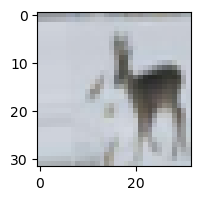

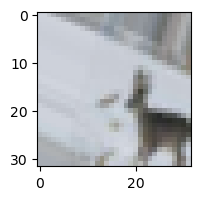

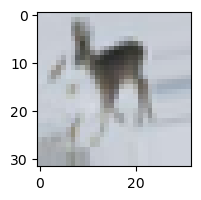

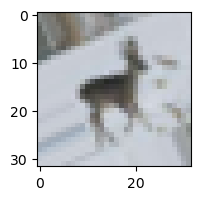

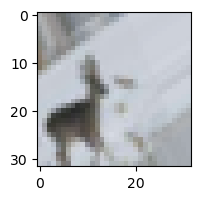

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cria um objeto gerador de dados que transforma as imagens

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Transforma uma imagem
test_img = train_images[20]
img = image.img_to_array(test_img) # converte a imagem pra um array numpy 
img = img.reshape((1,) + img.shape)

i = 0
# Esse Loop até o break salva as imagens no diretório atual
for batch in datagen.flow(img, save_prefix='test',save_format='jpeg'):
    plt.figure(i,figsize=(2,2))
    plot = plt.imshow(image.img_to_array(batch[0])/255.0) # normalizando os pxels 255
    i+=1
    if i > 4: # mostra 4 imagens
        break
plt.show()


<p>Agora o modelo tem 5 imagens a partir de 1 para treino</p>


<h2>Modelos Pré-Treinados</h2>

<p>A CNN sozinha (sem a Dense Layer) não faz outra coisa se não mapear a presença de elementos com base no input</p>
<p>Isso significa que podemos usar uma CNN Pré-Treinada com milhões de imagens para começarmos nosso modelo</p>
<p>E se determinarmos a presença de elementos todo o resto do nosso modelo só precisa determinar qual combinação desses elementos fazem uma imagem</p>

<h3>Ajuste Fino</h3>
<p>O modelo pré-treinado é então ajustado em um conjunto de dados menor e mais específico relacionado à tarefa que se deseja resolver. Durante esse processo, os pesos do modelo são atualizados com base nos novos dados específicos da tarefa, geralmente usando uma taxa de aprendizado menor do que durante o pré-treinamento</p>
<p>Geral -> Especifico</p>

<h3>Pegando um modelo pré-treinado</h3>

<p>IncludeTop -> importante argumento quando usamos um modelo pré treinado, se True -> trás as classificações junto, False não</p>

<p>Adiciona o Classificador</p>
<p>Usa tf.keras.layers.GlobalAvaragePooling2D()</p>
<p>Essa função passa um pooling de 5x5 que pega a media e retorna um vetor de 1280 elementos por filtro</p>
<p>Depois a camada de predição só precisa de 1 neuronio pra diferenciar cats/dogs</p>
<p>Passa como argumento pro modelo sequencial o modelo base, o globalavaragepooling e a camada de predicao</p>
